In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Input
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os


In [2]:
print("TensorFlow version:", tf.__version__)
print("Devices:", tf.config.list_physical_devices())

TensorFlow version: 2.16.2
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
base_dir = "./pest"   
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

In [ ]:
# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=False,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32

# Training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation data
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Test data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)



Found 2400 images belonging to 10 classes.
Found 600 images belonging to 10 classes.
Found 600 images belonging to 10 classes.


In [ ]:
#Following the 3 block VGG style
def create_simple_vgg_model(num_classes=10):
    model = models.Sequential([
        layers.Input(shape=(150, 150, 3)),
        
        # Block 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.2),
        
        # Block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.3),
        
        # Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.4),
        
        # Dense layers
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

model = create_simple_vgg_model() 

2025-10-13 12:10:06.042445: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-10-13 12:10:06.042470: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-10-13 12:10:06.042479: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-10-13 12:10:06.042497: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-10-13 12:10:06.042508: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
#def scheduler(epoch, lr):
#    if epoch < 10:
#        return float(lr)
#    else:
#        return float(lr * tf.math.exp(-0.1))
#
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_vgg_pest_model.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 150, 150, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 75, 75, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 37, 37, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 37, 37, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │             

 Total params: 505,642 (1.93 MB)

 Trainable params: 503,722 (1.92 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
class_weights = None  
# labels = train_generator.classes
# class_weights = compute_class_weight(
#     'balanced',
#     classes=np.unique(labels),
#     y=labels
# )
# class_weights = dict(enumerate(class_weights))

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.3319 - loss: 1.8650
Epoch 1: val_accuracy improved from 0.33000 to 0.37667, saving model to best_vgg_pest_model.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 208ms/step - accuracy: 0.3258 - loss: 1.8727 - val_accuracy: 0.3767 - val_loss: 1.9774 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.3149 - loss: 1.8597
Epoch 2: val_accuracy did not improve from 0.37667
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 195ms/step - accuracy: 0.3150 - loss: 1.8750 - val_accuracy: 0.3150 - val_loss: 1.9551 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.3428 - loss: 1.8212
Epoch 3: val_accuracy did not improve from 0.37667
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 200ms/step - accuracy: 0.3433 - loss: 1.8066 - val_accuracy: 0.3150 - val_loss: 2.0169 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.3431 - loss: 1.7969
Epoch 4: val_accuracy did not 

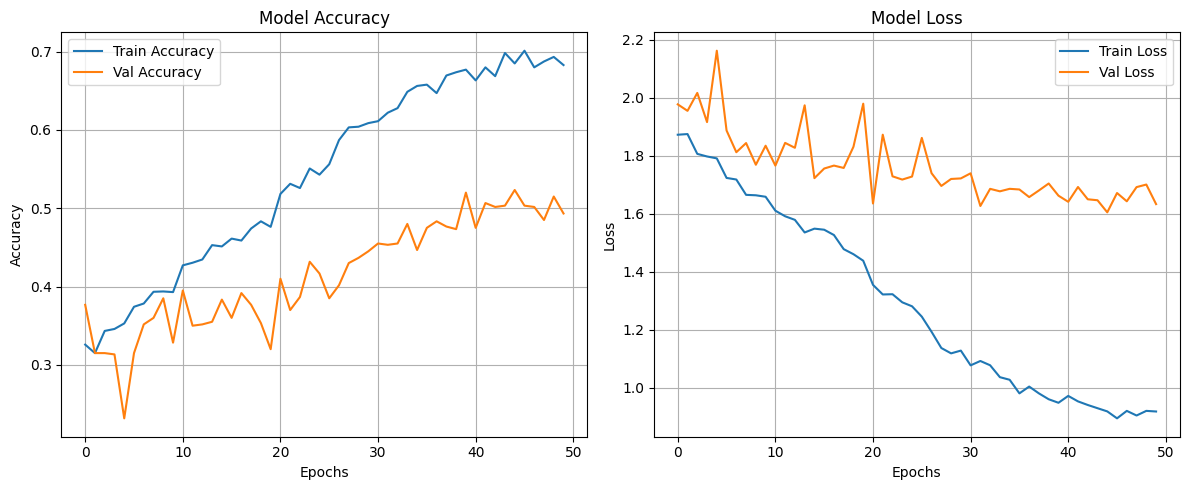

In [ ]:
# Training the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[early_stop, reduce_lr, checkpoint],
    class_weight=class_weights
)

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"\n Test accuracy: {test_acc * 100:.2f}%")

# Overfitting
train_generator_eval = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=False
)

train_loss, train_acc = model.evaluate(train_generator_eval)
print(f"Train accuracy: {train_acc * 100:.2f}%")
print(f"Validation accuracy: {history.history['val_accuracy'][-1] * 100:.2f}%")
print(f"Test accuracy: {test_acc * 100:.2f}%")

overfitting_gap = train_acc - test_acc
if overfitting_gap < 0.1:
    print(f" Generalized. Gap: {overfitting_gap * 100:.2f}%")
else:
    print(f"Overfitting. Gap: {overfitting_gap * 100:.2f}%")

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.7267 - loss: 0.8782

 Test accuracy: 72.67%
Found 2400 images belonging to 10 classes.


/opt/anaconda3/envs/tfenv1/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.7821 - loss: 0.7003
Train accuracy: 78.21%
Validation accuracy: 49.33%
Test accuracy: 72.67%
 Generalized. Gap: 5.54%
